In [1]:
import os
os.chdir('../../modules/')

In [633]:
from util.util import *
from util.losses import *
from util.pred_blocks import ConvEncoder, GRUDecoder
from likelihood_predictor import PlastPredictor
from vae_generator import PlastVAEGen
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm

In [3]:
%load_ext autoreload
%autoreload 2

import IPython.display as Disp
np.set_printoptions(suppress=True)

Most recent training data

In [187]:
df = pd.read_csv('../notebooks/research_notebooks/log.txt')

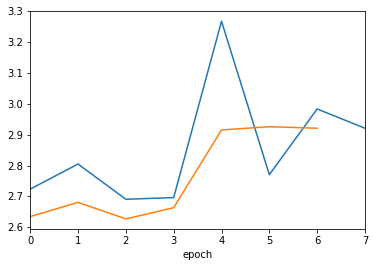

In [188]:
df[df.data_type == 'train'].groupby('epoch').mean()['tot_loss'].plot()
df[df.data_type == 'test'].groupby('epoch').mean()['tot_loss'].plot()

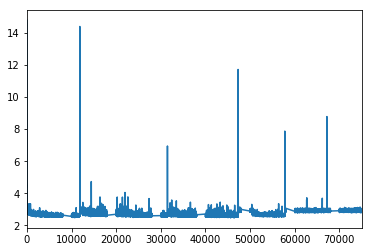

In [189]:
df[df.data_type == 'train']['bce_loss'].plot()
plt.show()

Running Tests

In [757]:
# Load Data
pl_ll = pd.read_pickle('../database/pl_likelihoods_v1.pkl')
org_ll = pd.read_pickle('../database/org_likelihoods_v1.pkl')
all_data = pd.concat([pl_ll, org_ll]).to_numpy()
test_data = pd.concat([pl_ll, org_ll]).sample(n=500).to_numpy()
gdb_test = pd.read_pickle('../database/gdb_vae_test.pkl').to_numpy()

In [692]:
out_smiles = []

In [758]:
# Build Model
max_len = 60
pvg = PlastVAEGen(params={'MAX_LENGTH': max_len, 'N_EPOCHS': 10, 'BATCH_SIZE': 10})

In [761]:
pvg.train(test_data, save_best=False, save_last=False, log=False, make_grad_gif=False)

KeyboardInterrupt: 

Validating reconstruction

In [737]:
sample_smiles = []
for i in range(pvg.sample.shape[0]):
    smile = decode_smiles(pvg.sample[i,:,:].squeeze(0).numpy(), pvg.params['ORD_DICT'])
    sample_smiles.append(smile)
idx = 2
sample_smiles[idx]

'CCCCCCCCOC(=O)C(C)(C1=CC=CC=C1)O________'

In [738]:
pvg.sample[idx,:,0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [739]:
out = F.softmax(pvg.out, 1)
out[idx,:,0].detach().numpy()

array([0.39436343, 0.01640011, 0.01811258, 0.0050836 , 0.01110586,
       0.00460911, 0.07637575, 0.02201269, 0.02238353, 0.01542936,
       0.02059183, 0.01997121, 0.02178522, 0.0183897 , 0.00855832,
       0.01231583, 0.01000328, 0.01946035, 0.01791234, 0.01654463,
       0.01973213, 0.01993127, 0.02396515, 0.01903585, 0.02047347,
       0.02087913, 0.02036179, 0.01878246, 0.02122745, 0.02189768,
       0.02012048, 0.02189446, 0.00028997], dtype=float32)

In [742]:
out_smile = decode_smiles(out[idx,:,:].detach().numpy(), pvg.params['ORD_DICT'], temp=0.3)
out_smile

'CCC=(C==(=CC=)=_=_)O=_____(_____________'

In [743]:
pvg.sample_loss

2.222604513168335

In [744]:
test_loss = vae_loss(pvg.sample, pvg.out, pvg.mu, pvg.logvar, pvg.params['MAX_LENGTH'])
test_loss[0]

tensor(2.2226, grad_fn=<AddBackward0>)

In [598]:
out_smiles.append(out_smile)

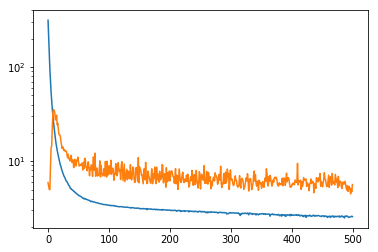

In [745]:
plt.plot(pvg.history['train_loss'], label='train')
plt.plot(pvg.history['val_loss'], label='val')
plt.yscale('log')
# plt.axvline(85, c='black', ls=':')
# plt.axvline(145, c='black', ls=':')
plt.show()

Generate GDB test set

In [751]:
gdb_smiles = []
i = 0
with open('../data/gdb17/GDB17.50000000.smi', 'r') as f:
    for line in f:
        if i % 500 == 0:
            gdb_smiles.append(line.split('\n')[0])
        i += 1
gdb_lls = np.zeros((len(gdb_smiles),))
gdb_data = {'smiles': gdb_smiles,
            'lls': gdb_lls}
df = pd.DataFrame(gdb_data)

In [752]:
gdb_data = df.to_numpy()
usable_smiles = [sm for sm in gdb_data[:,0] if len(sm) < 60]
char_dict, ord_dict = get_smiles_vocab(usable_smiles)

In [756]:
df.to_pickle('../database/gdb_vae_test.pkl')

Validating save and load

In [769]:
# Build Model
max_len = 60
pvg = PlastVAEGen(params={'MAX_LENGTH': max_len, 'N_EPOCHS': 10, 'BATCH_SIZE': 10})

# Train Model
pvg.train(test_data, save_best=True, save_last=True, log=False)

Epoch - 1  Train Loss - 288.92  Val Loss - 5.88
Epoch - 2  Train Loss - 172.71  Val Loss - 5.35
Epoch - 3  Train Loss - 113.9  Val Loss - 7.1
Epoch - 4  Train Loss - 79.79  Val Loss - 30.83
Epoch - 5  Train Loss - 58.77  Val Loss - 56.22
Epoch - 6  Train Loss - 44.0  Val Loss - 59.39
Epoch - 7  Train Loss - 34.58  Val Loss - 54.4
Epoch - 8  Train Loss - 28.02  Val Loss - 42.43
Epoch - 9  Train Loss - 23.42  Val Loss - 47.06
Epoch - 10  Train Loss - 19.76  Val Loss - 39.48


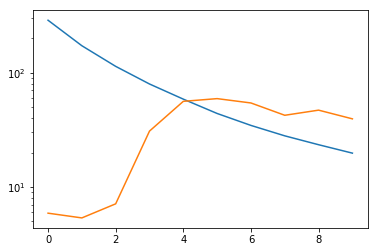

In [770]:
plt.plot(pvg.history['train_loss'], label='train')
plt.plot(pvg.history['val_loss'], label='val')
plt.yscale('log')
plt.show()

In [771]:
# Load Model
pvg_loaded = PlastVAEGen(params={'N_EPOCHS': 10, 'BATCH_SIZE': 10})
pvg_loaded.load('checkpoints/latest.ckpt')
pvg_loaded.train(test_data, save_best=False, save_last=False, log=False)

Epoch - 11  Train Loss - 17.01  Val Loss - 36.59
Epoch - 12  Train Loss - 15.01  Val Loss - 30.97
Epoch - 13  Train Loss - 13.22  Val Loss - 30.06
Epoch - 14  Train Loss - 11.79  Val Loss - 25.52
Epoch - 15  Train Loss - 10.73  Val Loss - 26.64
Epoch - 16  Train Loss - 9.83  Val Loss - 18.7
Epoch - 17  Train Loss - 9.04  Val Loss - 28.45
Epoch - 18  Train Loss - 8.37  Val Loss - 15.45
Epoch - 19  Train Loss - 7.8  Val Loss - 14.14
Epoch - 20  Train Loss - 7.41  Val Loss - 17.96


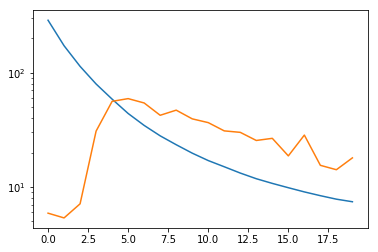

In [772]:
plt.plot(pvg_loaded.history['train_loss'], label='train')
plt.plot(pvg_loaded.history['val_loss'], label='val')
plt.yscale('log')
plt.show()